In [1]:
%run additional.ipynb

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [3]:
pandas.set_option('display.max_colwidth', 120)

In [4]:
PROFILE='ssh-py2'

# HLT2 nbody classification

did preselections:

* any sv.n, 
* any sv.minpt
* sv.nlt16 < 2

## Training channels (read data)

We will use just 11114001, 11296013, 11874042, 12103035, 13246001, 13264021

In [5]:
sig_train_modes_names = [11114001, 11296013, 11874042, 12103035, 13246001, 13264021]
bck_train_mode_name = 30000000
sig_train_files = ['mod_{}.csv'.format(name) for name in sig_train_modes_names]
bck_train_files = 'mod_30000000.csv'
folder = "datasets/prepared_hlt_body/"

In [6]:
# concat all signal data
if not os.path.exists(folder + 'signal_hlt2.csv'):
    concat_files(folder, sig_train_files, os.path.join(folder , 'signal_hlt2.csv'))

In [7]:
signal_data = pandas.read_csv(os.path.join(folder , 'signal_hlt2.csv'), sep='\t')
bck_data = pandas.read_csv(os.path.join(folder , bck_train_files), sep='\t')

In [8]:
signal_data.columns

Index([u'unique', u'mode', u'event_number', u'sv_number', u'pass_2body',
       u'pass_nbody', u'signal', u'sumpt', u'm', u'mcor', u'ipchi2', u'chi2',
       u'sumipchi2', u'fdr', u'nlt16', u'minpt', u'eta', u'pt', u'nmu', u'n',
       u'fdchi2', u'maxtchi2', u'ngood', u'nmu1', u'mupt', u'n1trk', u'sig',
       u'idx'],
      dtype='object')

## Counting events and svrs,
that passed **L0** and **GoodGenB** preselection (this data was generated by skim)

In [9]:
print 'Signal', statistic_length(signal_data)
print 'Bck', statistic_length(bck_data)

Signal {'SVR': 12367085, 'Events': 166059}
Bck {'SVR': 408147, 'Events': 38035}


In [10]:
total_bck_events = statistic_length(bck_data)['Events'] + empty_events[bck_train_mode_name]
total_signal_events_by_mode = dict()
for mode in sig_train_modes_names:
    total_signal_events_by_mode[mode] = statistic_length(signal_data[signal_data['mode'] == mode])['Events'] + empty_events[mode]

### events distribution by mode

In [11]:
print 'Bck:', total_bck_events
'Signal:', total_signal_events_by_mode

Bck: 111306


('Signal:',
 {11114001: 61102,
  11296013: 17149,
  11874042: 3942,
  12103035: 25250,
  13246001: 37313,
  13264021: 25165})

## Define variables

In [12]:
variables_base = ["n", "mcor", "chi2", "sumpt", "eta", "fdchi2", "minpt", "nlt16", "ipchi2", "n1trk"]

## Counting events and svrs,

which passed **pass_nbody** (equivalent Mike's preselections for nbody selection)

In [13]:
# hlt2 nbody selection
signal_data = signal_data[(signal_data['pass_nbody'] == 1) & (signal_data['mcor'] <= 10e3)]
bck_data = bck_data[(bck_data['pass_nbody'] == 1) & (bck_data['mcor'] <= 10e3)]

In [14]:
print 'Signal', statistic_length(signal_data)
print 'Bck', statistic_length(bck_data)

Signal {'SVR': 960600, 'Events': 150566}
Bck {'SVR': 21868, 'Events': 9664}


In [15]:
total_signal_events_by_mode_presel = dict()
for mode in sig_train_modes_names:
    total_signal_events_by_mode_presel[mode] = statistic_length(signal_data[signal_data['mode'] == mode])['Events']
total_bck_events_presel = statistic_length(bck_data)['Events']

### events distribution by mode

In [16]:
print 'Bck:', total_bck_events_presel
'Signal:', total_signal_events_by_mode_presel

Bck: 9664


('Signal:',
 {11114001: 53105,
  11296013: 16256,
  11874042: 3290,
  12103035: 21498,
  13246001: 33807,
  13264021: 22610})

In [17]:
signal_data.head()

,unique,mode,event_number,sv_number,pass_2body,pass_nbody,signal,sumpt,m,mcor,...,nmu,n,fdchi2,maxtchi2,ngood,nmu1,mupt,n1trk,sig,idx
1,11114001_0,11114001,0,1,1,1,1,6912.10,2806.110,4168.77,...,1,2,9653.910,1.20832,2,1,2972.750,2,1,1
2,11114001_0,11114001,0,2,1,1,1,3731.68,728.895,4429.24,...,2,2,7424.620,1.58733,2,2,2972.750,1,1,2
3,11114001_0,11114001,0,3,1,1,1,4698.27,1249.280,2144.50,...,1,2,1382.720,1.58733,2,1,758.924,1,1,3
5,11114001_1,11114001,1,1,1,1,1,4003.36,3530.930,4651.29,...,1,2,1102.850,1.20808,2,1,2611.970,2,1,1
9,11114001_1,11114001,1,5,1,1,1,2145.67,1520.500,2266.15,...,1,2,868.049,1.35907,2,1,1137.010,2,1,5


## Prepare train/test splitting

Divide events which passed alll preselections into two equal parts randomly

In [18]:
ds_train_signal, ds_train_bck, ds_test_signal, ds_test_bck = prepare_data(signal_data, bck_data, 'unique')

### train: counting events and svrs

In [19]:
print 'Signal', statistic_length(ds_train_signal)
print 'Bck', statistic_length(ds_train_bck)

Signal {'SVR': 479851, 'Events': 75283}
Bck {'SVR': 10759, 'Events': 4832}


In [20]:
train = pandas.concat([ds_train_bck, ds_train_signal])

### test: counting events and svrs

In [21]:
print 'Signal', statistic_length(ds_test_signal)
print 'Bck', statistic_length(ds_test_bck)

Signal {'SVR': 480749, 'Events': 75283}
Bck {'SVR': 11109, 'Events': 4832}


In [22]:
v, s = numpy.unique(train.unique.values, return_counts=True)

In [23]:
numpy.min(s), numpy.max(s), numpy.mean(s)

(1, 124, 6.1238220058665664)

In [24]:
test = pandas.concat([ds_test_bck, ds_test_signal])

## Define all total events in test samples
(which passed just l0 and goodgenB) using also empty events. Suppose that events which didn't pass **pass_nboby** also were equal randomly divided into training and test samples 

In [25]:
total_test_bck_events = (total_bck_events - total_bck_events_presel) // 2 + statistic_length(ds_test_bck)['Events']
total_test_signal_events = dict()
for mode in sig_train_modes_names:
    total_not_passed_signal = total_signal_events_by_mode[mode] - total_signal_events_by_mode_presel[mode]
    total_test_signal_events[mode] = total_not_passed_signal // 2 + \
        statistic_length(ds_test_signal[ds_test_signal['mode'] == mode])['Events']

In [26]:
print 'Bck total test events:', total_test_bck_events
'Signal total test events:', total_test_signal_events

Bck total test events: 55653


('Signal total test events:',
 {11114001: 30533,
  11296013: 8630,
  11874042: 1950,
  12103035: 12682,
  13246001: 18627,
  13264021: 12537})

# Different models

----------

In [28]:
import cPickle
if os.path.exists('models/hlt2_bodyn_experiments.pkl'):
    with open('models/hlt2_bodyn_experiments.pkl', 'r') as file_mn:
        estimators = cPickle.load(file_mn)

---------

## Base MN

In [29]:
from rep_ef.estimators import MatrixNetClassifier

In [30]:
params = {'connection_auth': 'AUTH_HEADERS', 'connection': 'skygrid', 'iterations': 2500, 'regularization': 0.02,
          'sync': False}

In [32]:
estimators = OrderedDict()
estimators['base'] = MatrixNetClassifier(train_features=variables_base, **params)
estimators['base'].fit(train, train['signal'])

MatrixNetClassifier(auto_stop=None, baseline_feature=None,
          command_line_params=None, connection='skygrid',
          connection_auth='AUTH_HEADERS', dump_filename=None,
          features_sample_rate_per_iteration=1.0, intervals=64,
          iterations=2500, max_features_per_iteration=6,
          regularization=0.02, sync=False,
          train_features=['n', 'mcor', 'chi2', 'sumpt', 'eta', 'fdchi2', 'minpt', 'nlt16', 'ipchi2', 'n1trk'],
          training_fraction=0.5)

## Partial fit

In [33]:
def get_best_svr_missing(data, estimator, channels, count=1):
    probs = estimator.predict_proba(data)[:, 1]
    train_prob = data.copy()
    train_prob['prediction'] = probs

    good_events = []
    for channel in set(train_prob['mode']) - set(channels):
        good_events.append(train_prob[train_prob['mode'] == channel].copy())
    add_events = []
    for channel in channels:
        for num, group in train_prob[train_prob['mode'] == channel].groupby('unique'):
            index = numpy.argsort(group['prediction'].values)[::-1]
            add_events.append(group.iloc[index[:count], :])
    good_events = pandas.concat(good_events + add_events)
    print len(good_events)
    return good_events

In [34]:
from rep.metaml import FoldingClassifier

### forest 2-folding training

In [36]:
from sklearn.ensemble import RandomForestClassifier
forest_base_partial = RandomForestClassifier(n_estimators=300, min_samples_leaf=100, max_depth=10,
                                             max_features=7, n_jobs=8)
forest_folding_top = FoldingClassifier(base_estimator=forest_base_partial, random_state=11, features=variables_base, 
                                       parallel_profile=PROFILE)
forest_folding_top.fit(train, train['signal'])

/moosefs/miniconda/envs/ipython_py2/lib/python2.7/site-packages/IPython/parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)


FoldingClassifier(base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features=7, max_leaf_nodes=None,
            min_samples_leaf=100, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=8,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
         features=['n', 'mcor', 'chi2', 'sumpt', 'eta', 'fdchi2', 'minpt', 'nlt16', 'ipchi2', 'n1trk'],
         n_folds=2, parallel_profile='ssh-py2', random_state=11)

### top forest

In [37]:
for rank in range(1, 3):
    good_events = get_best_svr(train, forest_folding_top, count=rank)
    ef_good = MatrixNetClassifier(train_features=variables_base, **params)
    ef_good.fit(good_events, good_events['signal'])
    estimators['forest selection, top {}'.format(rank)] = ef_good 

KFold prediction using folds column
86042
KFold prediction using folds column
148864


### blending, top2 by random forest + blending

In [38]:
forest_top_2 = get_best_svr(train, forest_folding_top, count=2)

KFold prediction using folds column
148864


In [41]:
from rep.estimators import XGBoostClassifier
import cPickle
def blend_scheme_fit(train, base, suf, model_file):
    blending_parts = OrderedDict()

    for nbody in [2, 3, 4]:
        temp = FoldingClassifier(base_estimator=base, random_state=11, features=variables_base, 
                                 parallel_profile=PROFILE)
        temp.fit(train[train.n == nbody], train[train.n == nbody]['signal'])
        blending_parts['body' + str(nbody) + suf] = temp
    for n_ch, ch in enumerate(sig_train_modes_names):
        temp = FoldingClassifier(base_estimator=base, random_state=11, features=variables_base,
                                 parallel_profile=PROFILE)
        temp_data = train[(train['mode'] == ch) | (train['mode'] == bck_train_mode_name)]
        temp.fit(temp_data, temp_data['signal'])
        blending_parts['ch' + str(n_ch) + suf] = temp
    import cPickle
    with open(model_file, 'w') as f:
        cPickle.dump(blending_parts, f)

def blend_scheme_predict(data, suf, model_file, mode='train'):
    blend_features = []
    with open(model_file, 'r') as f:
        blending_parts = cPickle.load(f)
    for nbody in [2, 3, 4]:
        temp_name = 'body' + str(nbody) + suf
        if mode == 'train':
            data.ix[data.n == nbody, temp_name] = blending_parts[temp_name].predict_proba(
                data[data.n == nbody])[:, 1]
            data.ix[data.n != nbody, temp_name] = blending_parts[temp_name].predict_proba(
                data[data.n != nbody])[:, 1]
        else:
            data[temp_name] = blending_parts[temp_name].predict_proba(data)[:, 1]
        blend_features.append(temp_name)
    for n_ch, ch in enumerate(sig_train_modes_names):
        temp_name = 'ch' + str(n_ch) + suf
        if mode == 'train':
            temp_key = ((data['mode'] == ch) | (data['mode'] == bck_train_mode_name))
            data.ix[temp_key, temp_name] = blending_parts[temp_name].predict_proba(
                data[temp_key])[:, 1]
            data.ix[~temp_key, temp_name] = blending_parts[temp_name].predict_proba(
                data[~temp_key])[:, 1]
        else:
            data[temp_name] = blending_parts[temp_name].predict_proba(data)[:, 1]
        blend_features.append(temp_name)
    return blend_features

In [42]:
base = XGBoostClassifier(n_estimators=300, nthreads=8, max_depth=7, subsample=0.5, eta=0.05, colsample=5)
blend_scheme_fit(forest_top_2, base, '_xgb', 'blending_part_xgb.pkl')
blend_features_forest = blend_scheme_predict(forest_top_2, '_xgb', 'blending_part_xgb.pkl')
blend_scheme_predict(test, '_xgb', 'blending_part_xgb.pkl', mode='test')

KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of da

['body2_xgb',
 'body3_xgb',
 'body4_xgb',
 'ch0_xgb',
 'ch1_xgb',
 'ch2_xgb',
 'ch3_xgb',
 'ch4_xgb',
 'ch5_xgb']

In [43]:
temp_mn = MatrixNetClassifier(train_features=variables_base + blend_features_forest, **params)
temp_mn.fit(forest_top_2, forest_top_2['signal'])
estimators['forest top 2, blending (xgb base)'] = temp_mn

----------

In [44]:
base = RandomForestClassifier(n_estimators=500, min_samples_leaf=50, max_depth=6,
                              max_features=7, n_jobs=8)

blend_scheme_fit(forest_top_2, base, '_forest', 'blending_part_forest.pkl')
blend_features_forest_f = blend_scheme_predict(forest_top_2, '_forest', 'blending_part_forest.pkl')
blend_scheme_predict(test, '_forest', 'blending_part_forest.pkl', mode='test')

KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of da

['body2_forest',
 'body3_forest',
 'body4_forest',
 'ch0_forest',
 'ch1_forest',
 'ch2_forest',
 'ch3_forest',
 'ch4_forest',
 'ch5_forest']

In [45]:
temp_mn = MatrixNetClassifier(train_features=variables_base + blend_features_forest_f, **params)
                                     
temp_mn.fit(forest_top_2, forest_top_2['signal'])
estimators['forest top 2, blending (forest base)'] = temp_mn

-----------

In [46]:
base = XGBoostClassifier(n_estimators=300, nthreads=8, max_depth=7, subsample=0.5, eta=0.05, colsample=5)
blend_scheme_fit(train, base, '_all_xgb', 'blending_part_all.pkl')
blend_features = blend_scheme_predict(train, '_all_xgb', 'blending_part_all.pkl')
blend_scheme_predict(test, '_all_xgb', 'blending_part_all.pkl', mode='test')

KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of da

['body2_all_xgb',
 'body3_all_xgb',
 'body4_all_xgb',
 'ch0_all_xgb',
 'ch1_all_xgb',
 'ch2_all_xgb',
 'ch3_all_xgb',
 'ch4_all_xgb',
 'ch5_all_xgb']

In [47]:
temp_mn = MatrixNetClassifier(train_features=variables_base + blend_features, **params)
temp_mn.fit(train, train['signal'])
estimators['blending (xgb base)'] = temp_mn

--------

In [48]:
base = RandomForestClassifier(n_estimators=500, min_samples_leaf=50, max_depth=6,
                              max_features=7, n_jobs=8)

blend_scheme_fit(train, base, '_all_forest', 'blending_part_all_forest.pkl')
blend_features = blend_scheme_predict(train, '_all_forest', 'blending_part_all_forest.pkl')
blend_scheme_predict(test, '_all_forest', 'blending_part_all_forest.pkl', mode='test')

KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using folds column
KFold prediction using random classifier (length of da

['body2_all_forest',
 'body3_all_forest',
 'body4_all_forest',
 'ch0_all_forest',
 'ch1_all_forest',
 'ch2_all_forest',
 'ch3_all_forest',
 'ch4_all_forest',
 'ch5_all_forest']

### 2-folding, top forest (use all svr for bad channels)

In [49]:
for rank in range(1, 3):
    good_events = get_best_svr_missing(train, forest_folding_top, [11114001, 12103035, 13246001, 13264021], 
                                       count=rank)
    ef_good = MatrixNetClassifier(train_features=variables_base, **params)
    ef_good.fit(good_events, good_events['signal'])
    estimators['forest selection partial, top {}'.format(rank)] = ef_good 

KFold prediction using folds column
142625
KFold prediction using folds column
196752


In [50]:
import cPickle
with open("models/hlt2_bodyn_experiments.pkl", 'w') as f:
    cPickle.dump(estimators, f)

### Channels forest, top-1, 2

In [51]:
def get_best_svr_by_channel(data, feature_mask, count=1):
    add_events = []
    for id_est, channel in enumerate(sig_train_modes_names):
        train_part = data[(data['mode'] == channel)]
        for num, group in train_part.groupby('unique'):
            index = numpy.argsort(group[feature_mask.format(id_est)].values)[::-1]
            add_events.append(group.iloc[index[:count], :])
    good_events = pandas.concat([data[(data['mode'] == bck_train_mode_name)]] + add_events)
    print len(good_events)
    return good_events

In [ ]:
for rank in [1, 2]:
    good_events = get_best_svr_by_channel(train, 'ch{}_all_xgb', rank)
    temp_mn = MatrixNetClassifier(train_features=variables_base, **params)
    temp_mn.fit(good_events, good_events['signal'])
    estimators['xgb top-{} in channel'.format(rank)] = temp_mn

86042
148864


In [ ]:
for rank in [1, 2]:
    good_events = get_best_svr_by_channel(train, 'ch{}_all_forest', rank)
    temp_mn = MatrixNetClassifier(train_features=variables_base, **params)
    temp_mn.fit(good_events, good_events['signal'])
    estimators['forest top-{} in channel'.format(rank)] = temp_mn

In [ ]:
import cPickle
with open("models/hlt2_bodyn_experiments.pkl", 'w') as f:
    cPickle.dump(estimators, f)

----------------

In [56]:
estimators.keys()

['base',
 'forest selection, top 1',
 'forest selection, top 2',
 'forest top 2, blending (xgb base)',
 'forest top 2, blending (forest base)',
 'blending (xgb base)',
 'forest selection partial, top 1',
 'forest selection partial, top 2',
 'xgb top-1 in channel',
 'xgb top-2 in channel',
 'forest top-1 in channel',
 'forest top-2 in channel']

# Report

In [57]:
thresholds = dict()
test_bck = test[test['signal'] == 0]
RATE = [2500., 4000.]
events_pass = dict()
for name, cl in estimators.items():
    prob = cl.predict_proba(test_bck)
    thr, result = calculate_thresholds(test_bck, prob, total_test_bck_events, rates=RATE)
    for rate, val in result.items():
        events_pass['{}-{}'.format(rate, name)] = val[1]
    thresholds[name] = thr
    print name, result

base {4000.0: (0.99375398951127847, 222, 0.00398900328823244), 2500.0: (0.99574273802391922, 139, 0.002497619175965357)}
forest selection, top 1 {4000.0: (0.94724378810702825, 222, 0.00398900328823244), 2500.0: (0.97082473025541838, 139, 0.002497619175965357)}
forest selection, top 2 {4000.0: (0.97379306747952554, 222, 0.00398900328823244), 2500.0: (0.98440154978848426, 139, 0.002497619175965357)}
forest top 2, blending (xgb base) {4000.0: (0.97721875441733586, 222, 0.00398900328823244), 2500.0: (0.98846945069143144, 139, 0.002497619175965357)}
forest top 2, blending (forest base) {4000.0: (0.97525218135906044, 222, 0.00398900328823244), 2500.0: (0.98594677976694267, 139, 0.002497619175965357)}
blending (xgb base) {4000.0: (0.99544135292303726, 222, 0.00398900328823244), 2500.0: (0.99722061641299065, 139, 0.002497619175965357)}
forest selection partial, top 1 {4000.0: (0.97966820762065687, 222, 0.00398900328823244), 2500.0: (0.98707164425428273, 139, 0.002497619175965357)}
forest selec

In [58]:
import cPickle
with open("models/hlt2_bodyn_experiments.pkl", 'w') as f:
    cPickle.dump(estimators, f)

## Final efficiencies for each mode

In [109]:
train_modes_eff, statistic = result_statistic(estimators, sig_train_modes_names, 
                                              test[test['signal'] == 1],
                                              thresholds, RATE, total_test_signal_events)

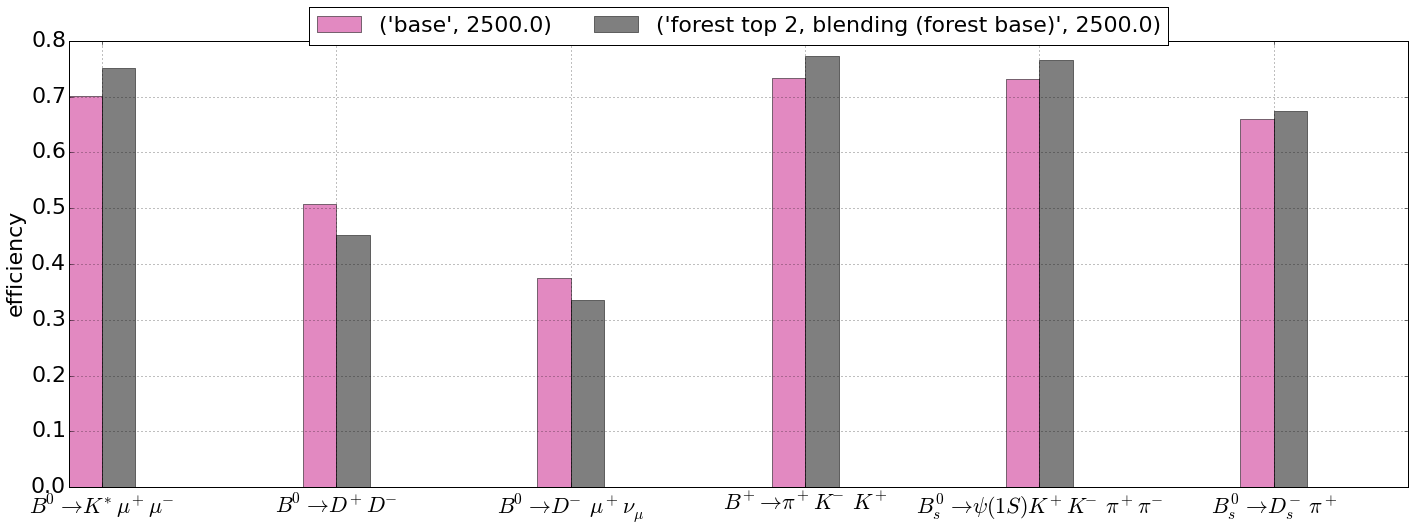

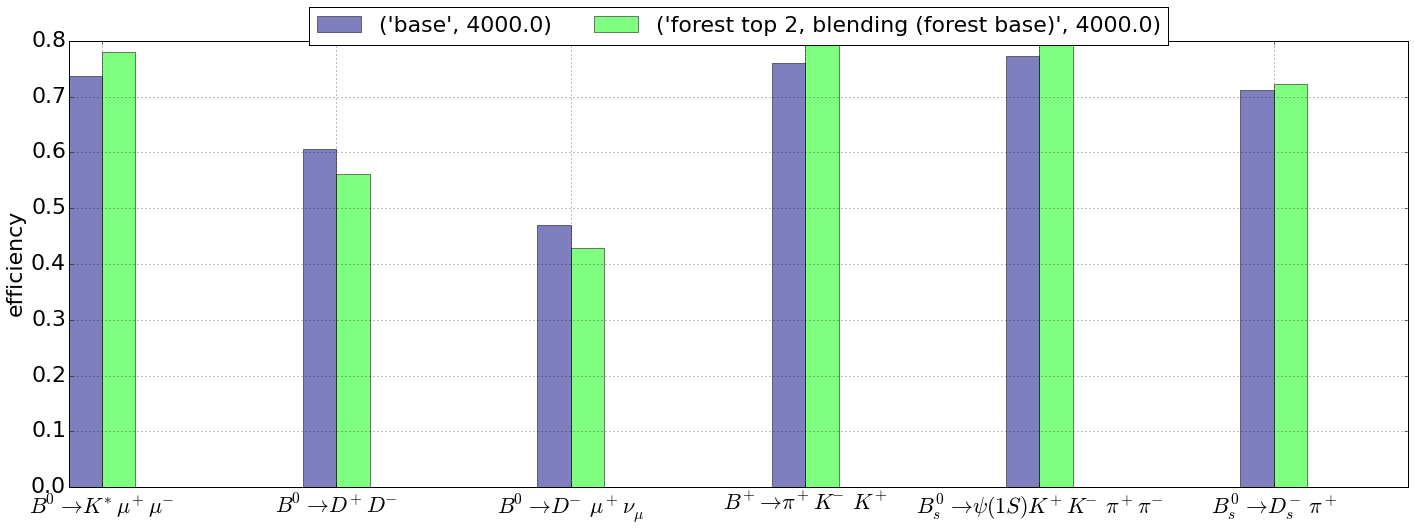

In [110]:
from rep.plotting import BarComparePlot
xticks_labels = ['$B^0 \\to K^*\mu^+\mu^-$', "$B^0 \\to D^+D^-$", "$B^0 \\to D^- \mu^+ \\nu_{\mu}$", 
                 '$B^+ \\to \pi^+ K^-K^+$', '$B^0_s \\to \psi(1S) K^+K^-\pi^+\pi^-$', '$B^0_s \\to D_s^-\pi^+$']
for r in RATE:
    new_dict = [] 
    for key, val in train_modes_eff.iteritems():
        if (('base' == key[0]) or ('forest base' in key[0])) and r == key[1]:
            new_dict.append((key, val))
    new_dict = dict(new_dict)        
    BarComparePlot(new_dict).plot(new_plot=True, figsize=(24, 8), ylabel='efficiency', fontsize=22)
    xticks(1 + 7 * numpy.arange(6), xticks_labels, rotation=0)
    lgd = legend(bbox_to_anchor=(0.5, 1.1), loc='upper center', ncol=2, fontsize=22)
# plt.savefig('hlt2-experiments.pdf' , format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

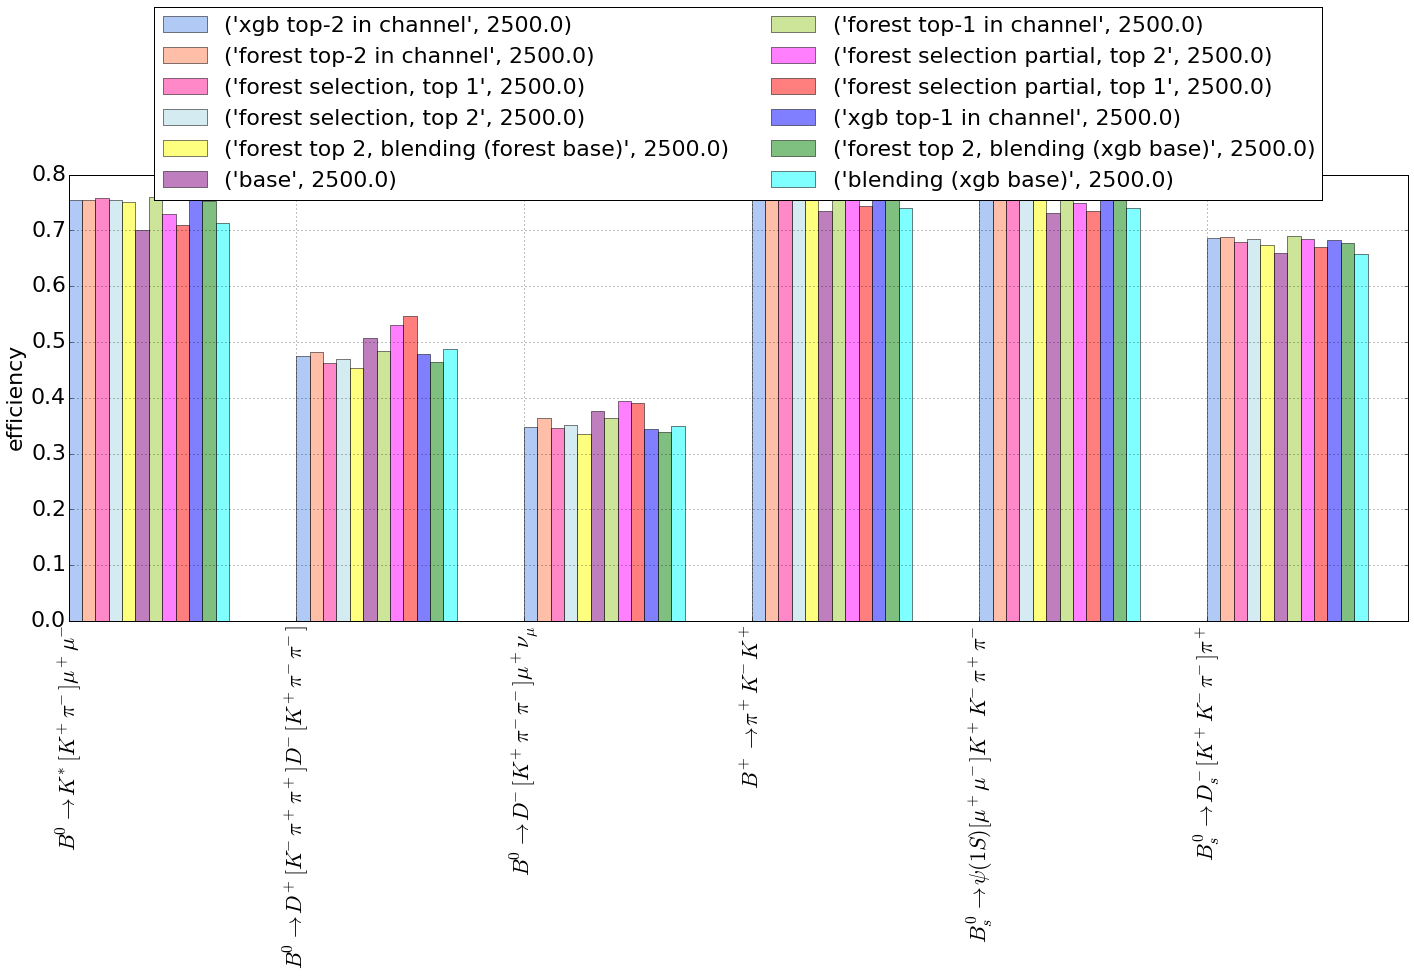

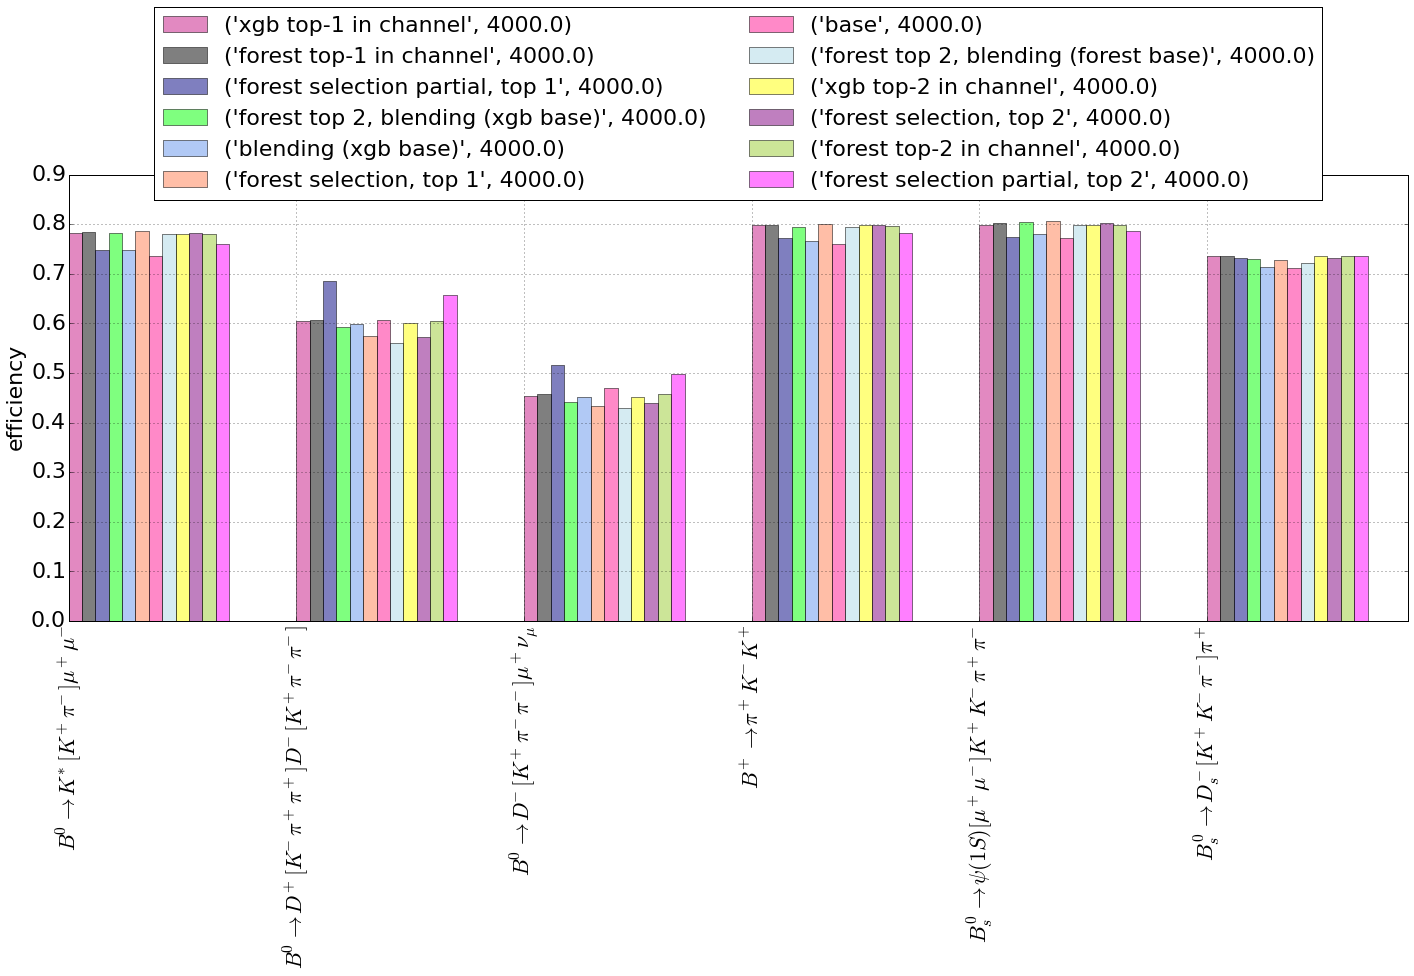

In [111]:
from rep.plotting import BarComparePlot
for r in RATE:
    new_dict = [] 
    for key, val in train_modes_eff.iteritems():
        if r == key[1]:
            new_dict.append((key, val))
    new_dict = dict(new_dict)        
    BarComparePlot(new_dict).plot(new_plot=True, figsize=(24, 8), ylabel='efficiency', fontsize=22)
    lgd = legend(bbox_to_anchor=(0.5, 1.4), loc='upper center', ncol=2, fontsize=22)
# plt.savefig('hlt2-experiments.pdf' , format='pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

# Best model; all channels efficiencies

In [69]:
from collections import defaultdict
all_channels = []
efficiencies = defaultdict(OrderedDict)
for mode in empty_events.keys():
    if mode in set(sig_train_modes_names) or mode == bck_train_mode_name:
        continue
    df = pandas.read_csv(os.path.join(folder , 'mod_{}.csv'.format(mode)), sep='\t')
    if len(df) <= 0:
        continue
    total_events = statistic_length(df)['Events'] + empty_events[mode]
    df = df[(df['pass_nbody'] == 1) & (df['mcor'] <= 10e3)]
    passed_events = statistic_length(df)['Events']
    blend_scheme_predict(df, '_xgb', 'blending_part_xgb.pkl', mode='test')
    blend_scheme_predict(df, '_forest', 'blending_part_forest.pkl', mode='test')
    blend_scheme_predict(df, '_all_xgb', 'blending_part_all.pkl', mode='test')
    blend_scheme_predict(df, '_all_forest', 'blending_part_all_forest.pkl', mode='test')
    all_channels.append(df)
    for name, cl in estimators.items():
        prob = cl.predict_proba(df)
        for rate, thresh in thresholds[name].items():
            eff = final_eff_for_mode(df, prob, total_events, thresh)
            latex_name = '$' + Samples[str(mode)]['root'].replace("#", "\\") + '$'
            efficiencies[(name, rate)][latex_name] = eff

KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data passed not equal to length of train)
KFold prediction using random classifier (length of data pas

In [107]:
for key, val in efficiencies.items():
    for key_2, val_2 in val.items():
        if val_2 <= 0.1:
            efficiencies[key].pop(key_2)

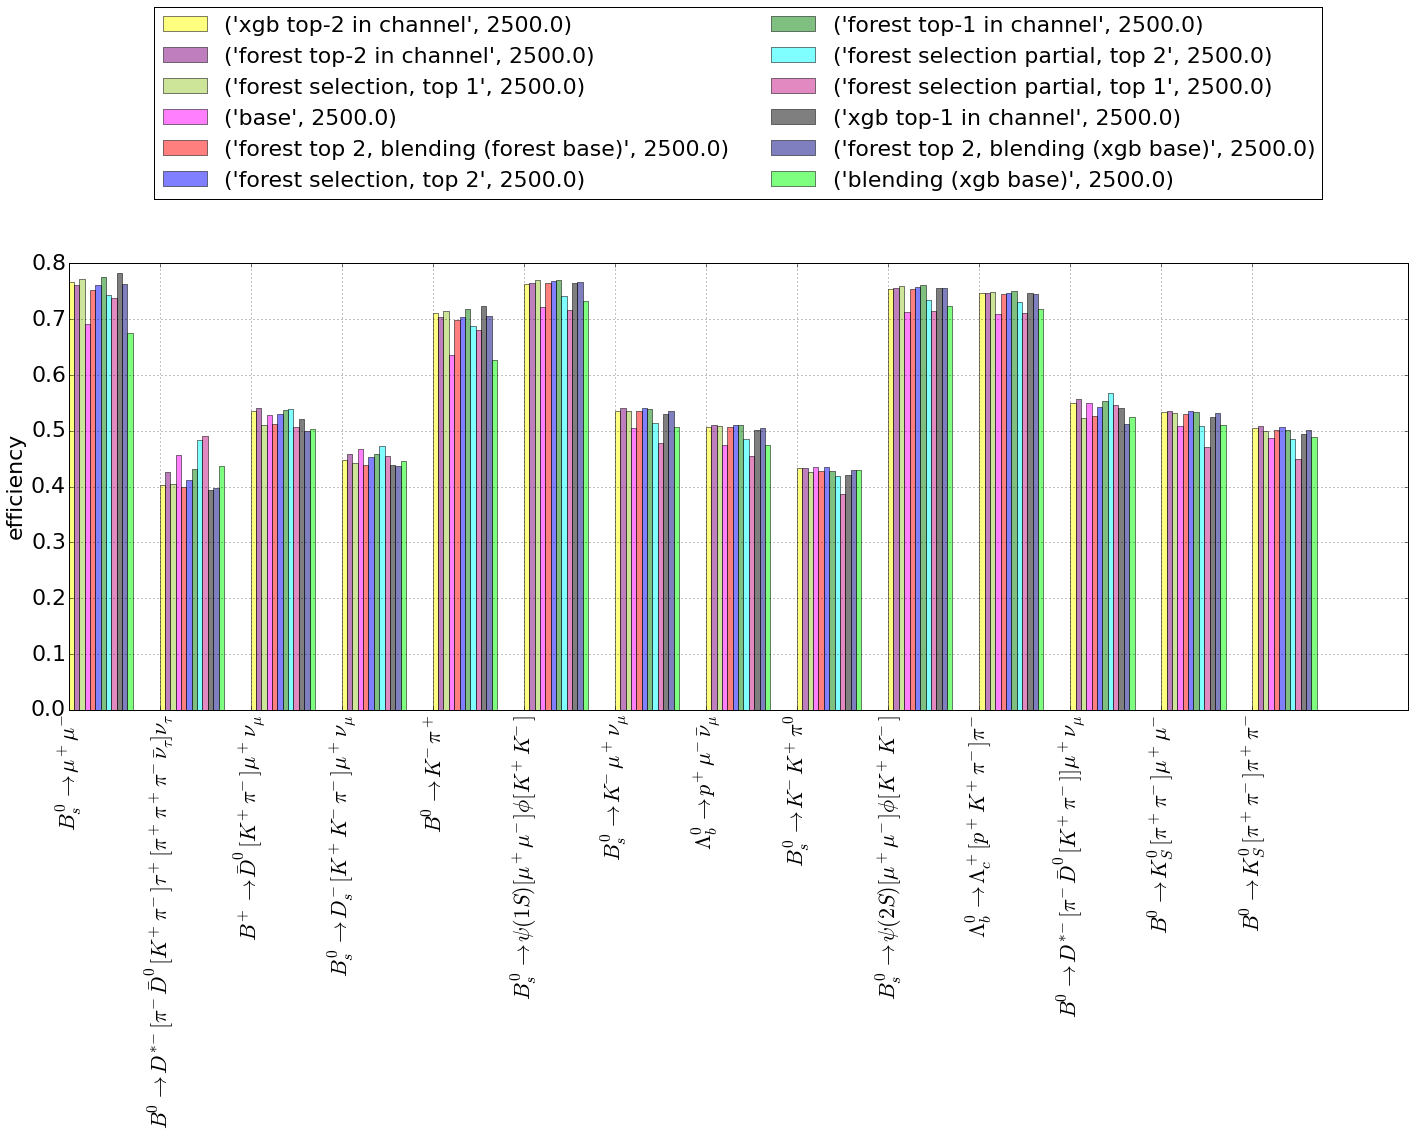

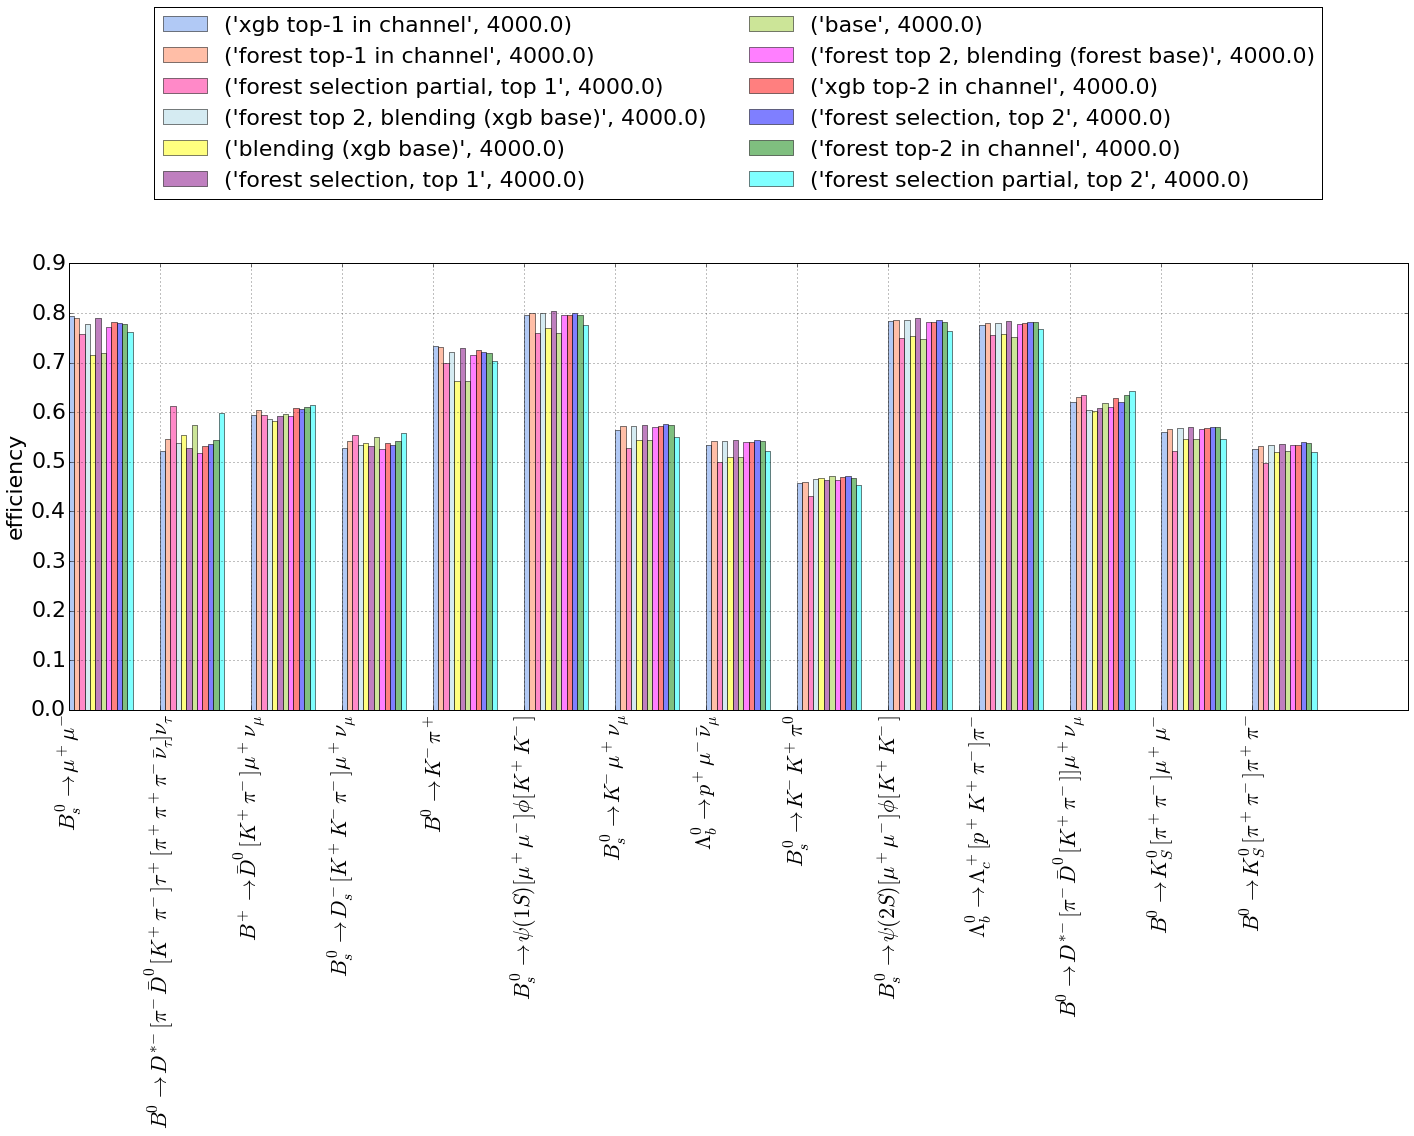

In [108]:
from rep.plotting import BarComparePlot
for r in RATE:
    new_dict = [] 
    for key, val in efficiencies.iteritems():
        if r == key[1]:
            new_dict.append((key, val))
    new_dict = dict(new_dict)        
    BarComparePlot(new_dict).plot(new_plot=True, figsize=(24, 8), ylabel='efficiency', fontsize=22)
    lgd = legend(bbox_to_anchor=(0.5, 1.6), loc='upper center', ncol=2, fontsize=22)

## Plot rocs by events

In [78]:
from rep.plotting import FunctionsPlot
def plot_rocs(plots, shift=1.3, modes='training', xlim=(0.02, 0.06), ylim=(0.65, 0.85)):
    FunctionsPlot(plots).plot(new_plot=True, xlim=xlim, ylim=ylim)
    plot([1. * events_pass['2500.0-base'] / statistic_length(ds_test_bck)['Events']] * 2, 
         [0., 1], 'b--', label='rate: 2.5 kHz')
    plot([1. * events_pass['4000.0-base'] / statistic_length(ds_test_bck)['Events']] * 2, 
         [0., 1], 'g--', label='rate: 4. kHz')
    lgd = legend(loc='upper center', fontsize=16, bbox_to_anchor=(0.5, shift), ncol=3)
    title('ROC for events ({} decays)'.format(modes), fontsize=20)
    xlabel('FRP, background events efficiency', fontsize=20)
    ylabel('TPR, signal events efficiency', fontsize=20)

base AUC: 0.955141501297
forest selection, top 1 AUC: 0.959043253806
forest selection, top 2 AUC: 0.958830563278


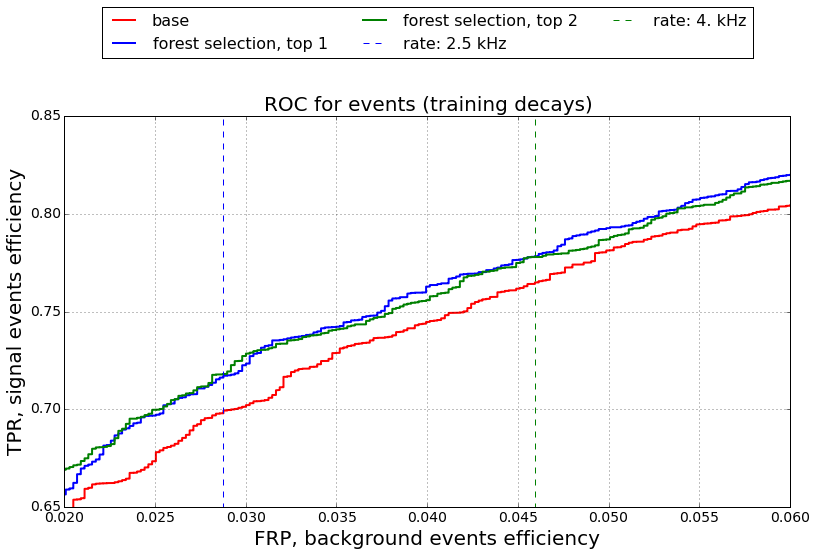

In [74]:
plots = OrderedDict()
for key in ['base', 'forest selection, top 1', 'forest selection, top 2']:
    plots[key] = plot_roc_events(estimators[key], test[test['signal'] == 1], test[test['signal'] == 0], key)
plot_rocs(plots)
plt.savefig('img/roc_training_top.pdf' , format='pdf', bbox_inches='tight')

base AUC: 0.897540507956
forest selection, top 1 AUC: 0.887598478784
forest selection, top 2 AUC: 0.887829296524


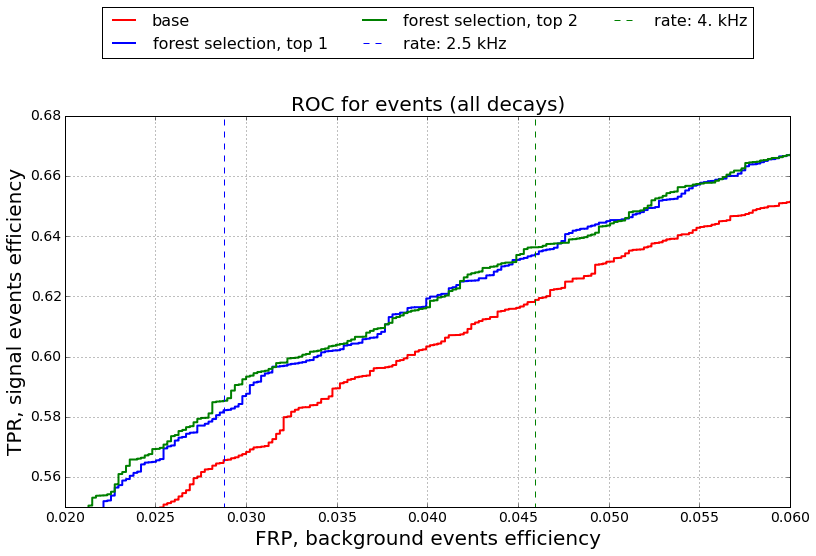

In [79]:
plots = OrderedDict()
for key in ['base', 'forest selection, top 1', 'forest selection, top 2']:
    plots[key] = plot_roc_events(estimators[key], pandas.concat([test[test['signal'] == 1]] + all_channels),
                                 test[test['signal'] == 0], key)
plot_rocs(plots, modes='all', xlim=(0.02, 0.06), ylim=(0.55, 0.68))
plt.savefig('img/roc_all_top.pdf' , format='pdf', bbox_inches='tight')

base AUC: 0.955141501297
forest selection partial, top 1 AUC: 0.960856762882
forest selection partial, top 2 AUC: 0.961304298657


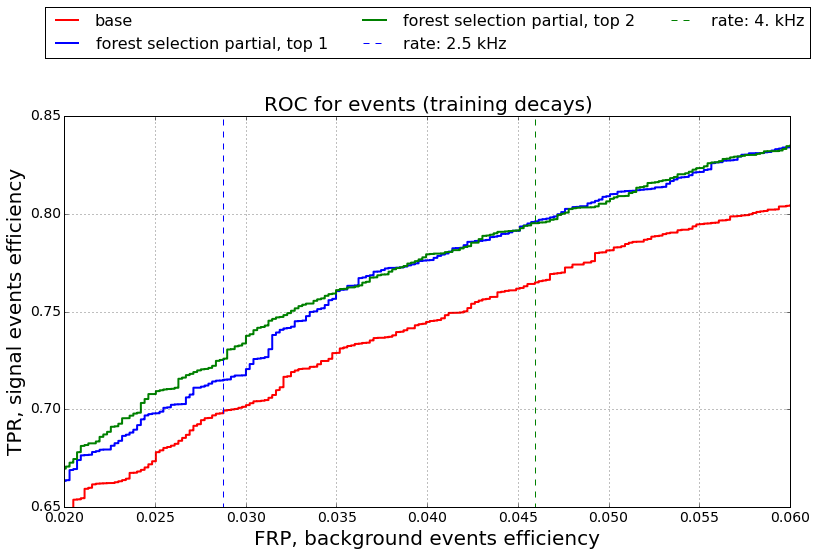

In [76]:
plots = OrderedDict()
for key in ['base', 'forest selection partial, top 1', 'forest selection partial, top 2']:
    plots[key] = plot_roc_events(estimators[key], test[test['signal'] == 1], test[test['signal'] == 0], key)
plot_rocs(plots)
plt.savefig('img/roc_training_top_partial.pdf' , format='pdf', bbox_inches='tight')

base AUC: 0.897540507956
forest selection partial, top 1 AUC: 0.90247856949
forest selection partial, top 2 AUC: 0.900624881021


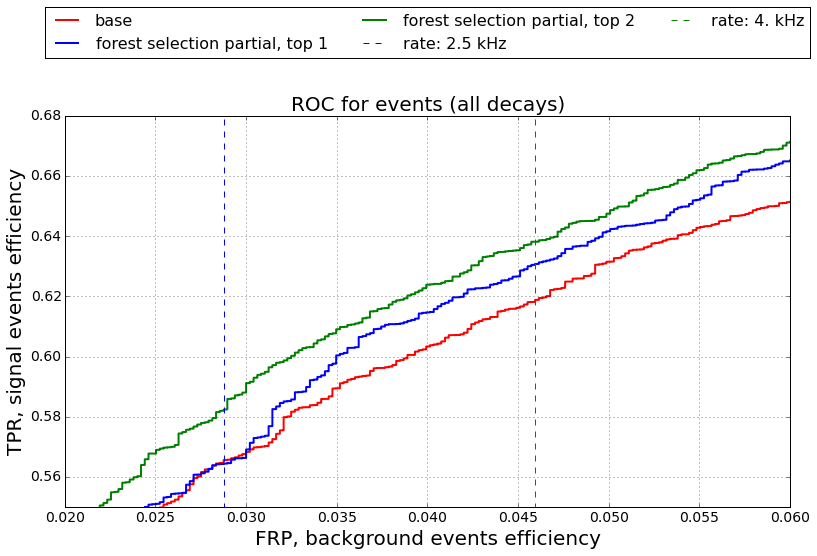

In [80]:
plots = OrderedDict()
for key in ['base', 'forest selection partial, top 1', 'forest selection partial, top 2']:
    plots[key] = plot_roc_events(estimators[key], pandas.concat([test[test['signal'] == 1]] + all_channels),
                                 test[test['signal'] == 0], key)
plot_rocs(plots, modes='all', xlim=(0.02, 0.06), ylim=(0.55, 0.68))
plt.savefig('img/roc_all_top_partial.pdf' , format='pdf', bbox_inches='tight')

base AUC: 0.955141501297
forest top-1 in channel AUC: 0.960303128293
forest top-2 in channel AUC: 0.959693395126


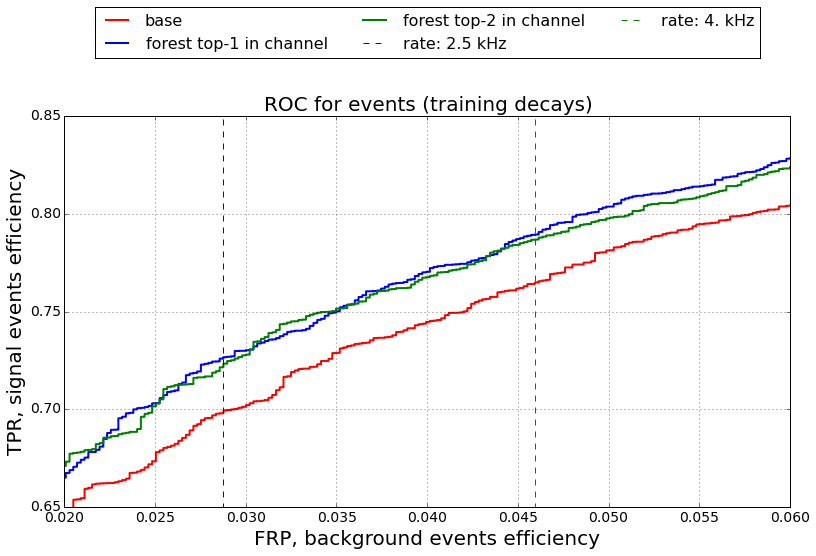

In [84]:
plots = OrderedDict()
for key in ['base', 'forest top-1 in channel', 'forest top-2 in channel']:
    plots[key] = plot_roc_events(estimators[key], test[test['signal'] == 1], test[test['signal'] == 0], key)
plot_rocs(plots)
plt.savefig('img/roc_training_top_forest.pdf' , format='pdf', bbox_inches='tight')

base AUC: 0.897540507956
forest top-1 in channel AUC: 0.892192941604
forest top-2 in channel AUC: 0.891210950224


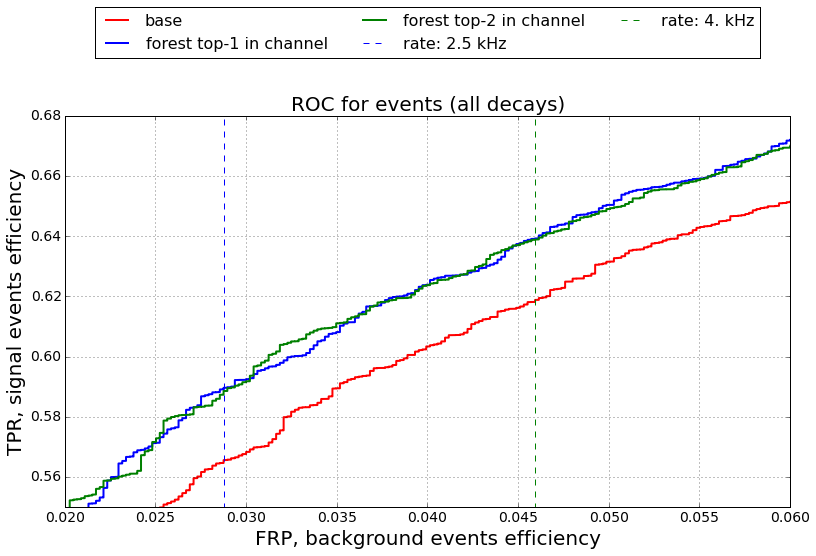

In [90]:
plots = OrderedDict()
for key in ['base', 'forest top-1 in channel', 'forest top-2 in channel']:
    plots[key] = plot_roc_events(estimators[key], pandas.concat([test[test['signal'] == 1]] + all_channels), 
                                 test[test['signal'] == 0], key)
plot_rocs(plots, modes='all', xlim=(0.02, 0.06), ylim=(0.55, 0.68))
plt.savefig('img/roc_all_top_forest.pdf' , format='pdf', bbox_inches='tight')

base AUC: 0.955141501297
xgb top-1 in channel AUC: 0.960241773896
xgb top-2 in channel AUC: 0.959917130038


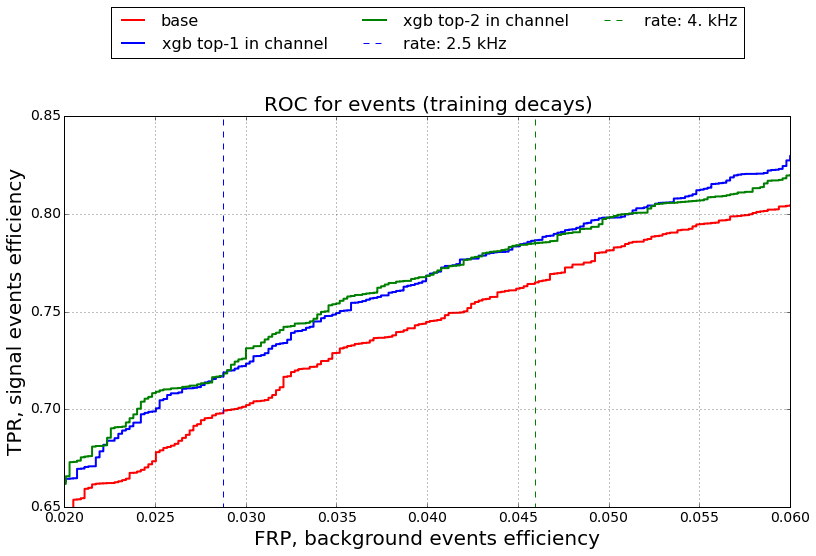

In [85]:
plots = OrderedDict()
for key in ['base', 'xgb top-1 in channel', 'xgb top-2 in channel']:
    plots[key] = plot_roc_events(estimators[key], test[test['signal'] == 1], test[test['signal'] == 0], key)
plot_rocs(plots)
plt.savefig('img/roc_training_top_xgb.pdf' , format='pdf', bbox_inches='tight')

base AUC: 0.897540507956
xgb top-1 in channel AUC: 0.890604249363
xgb top-2 in channel AUC: 0.890286580596


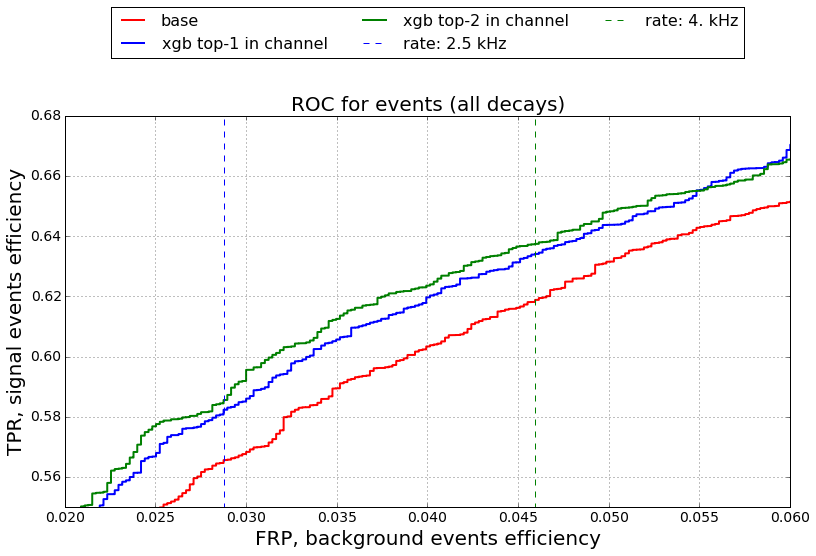

In [91]:
plots = OrderedDict()
for key in ['base', 'xgb top-1 in channel', 'xgb top-2 in channel']:
    plots[key] = plot_roc_events(estimators[key], pandas.concat([test[test['signal'] == 1]] + all_channels), 
                                 test[test['signal'] == 0], key)
plot_rocs(plots, modes='all', xlim=(0.02, 0.06), ylim=(0.55, 0.68))
plt.savefig('img/roc_all_top_xgb.pdf' , format='pdf', bbox_inches='tight')

base AUC: 0.955141501297
forest selection, top 1 AUC: 0.959043253806
forest selection, top 2 AUC: 0.958830563278
forest selection partial, top 1 AUC: 0.960856762882
forest selection partial, top 2 AUC: 0.961304298657
forest top-1 in channel AUC: 0.960303128293
forest top-2 in channel AUC: 0.959693395126
xgb top-1 in channel AUC: 0.960241773896
xgb top-2 in channel AUC: 0.959917130038


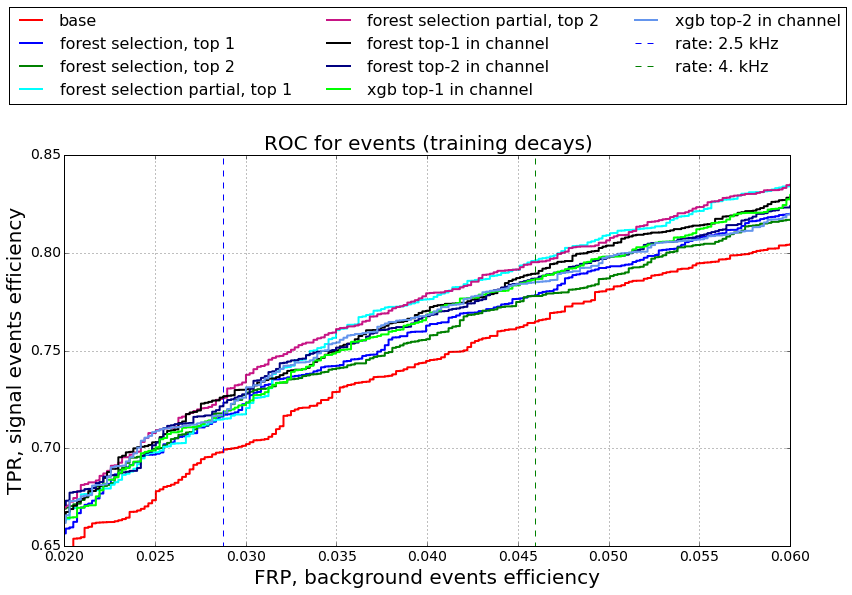

In [98]:
plots = OrderedDict()
for key in ['base', 
            'forest selection, top 1', 'forest selection, top 2',
            'forest selection partial, top 1', 'forest selection partial, top 2',
            'forest top-1 in channel', 'forest top-2 in channel', 
            'xgb top-1 in channel', 'xgb top-2 in channel']:
    plots[key] = plot_roc_events(estimators[key], test[test['signal'] == 1], test[test['signal'] == 0], key)
plot_rocs(plots, shift=1.4)
plt.savefig('img/roc_training_all.pdf' , format='pdf', bbox_inches='tight')

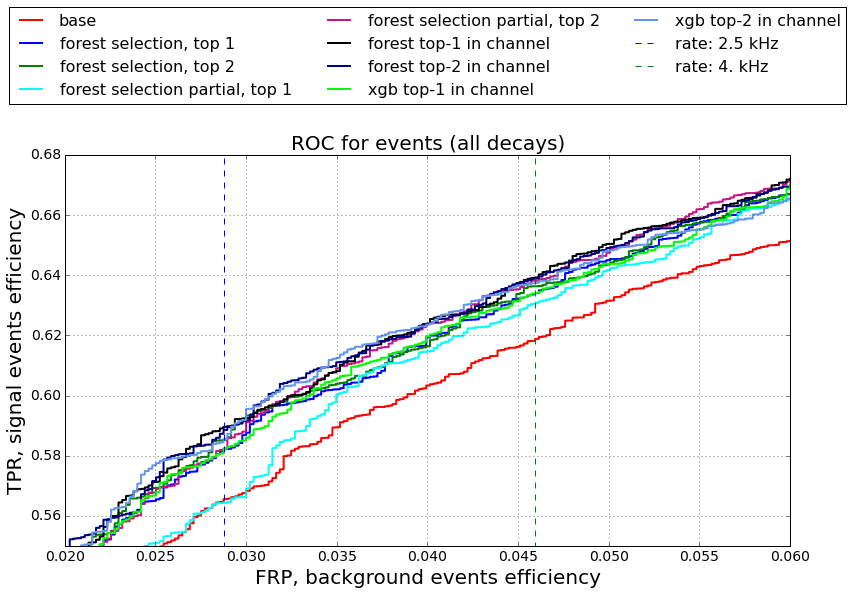

In [97]:
# plots = OrderedDict()
# for key in ['base', 
#             'forest selection, top 1', 'forest selection, top 2', 
#             'forest selection partial, top 1', 'forest selection partial, top 2',
#             'forest top-1 in channel', 'forest top-2 in channel', 
#             'xgb top-1 in channel', 'xgb top-2 in channel']:
#     plots[key] = plot_roc_events(estimators[key], pandas.concat([test[test['signal'] == 1]] + all_channels), 
#                                  test[test['signal'] == 0], key)
plot_rocs(plots, shift=1.4, modes='all', xlim=(0.02, 0.06), ylim=(0.55, 0.68))
plt.savefig('img/roc_all.pdf' , format='pdf', bbox_inches='tight')

--------------------

In [99]:
plots_all = OrderedDict()
for key, value in estimators.items():
    plots_all[key] = plot_roc_events(value, pandas.concat([test[test['signal'] == 1]] + all_channels), 
                                     test[test['signal'] == 0], key)

base AUC: 0.897540507956
forest selection, top 1 AUC: 0.887598478784
forest selection, top 2 AUC: 0.887829296524
forest top 2, blending (xgb base) AUC: 0.88628903539
forest top 2, blending (forest base) AUC: 0.88762946123
blending (xgb base) AUC: 0.894171879608
forest selection partial, top 1 AUC: 0.90247856949
forest selection partial, top 2 AUC: 0.900624881021
xgb top-1 in channel AUC: 0.890604249363
xgb top-2 in channel AUC: 0.890286580596
forest top-1 in channel AUC: 0.892192941604
forest top-2 in channel AUC: 0.891210950224


In [100]:
plots = OrderedDict()
for key, value in estimators.items():
    plots[key] = plot_roc_events(value, test[test['signal'] == 1], test[test['signal'] == 0], key)

base AUC: 0.955141501297
forest selection, top 1 AUC: 0.959043253806
forest selection, top 2 AUC: 0.958830563278
forest top 2, blending (xgb base) AUC: 0.959092223368
forest top 2, blending (forest base) AUC: 0.958006369344
blending (xgb base) AUC: 0.955108510531
forest selection partial, top 1 AUC: 0.960856762882
forest selection partial, top 2 AUC: 0.961304298657
xgb top-1 in channel AUC: 0.960241773896
xgb top-2 in channel AUC: 0.959917130038
forest top-1 in channel AUC: 0.960303128293
forest top-2 in channel AUC: 0.959693395126


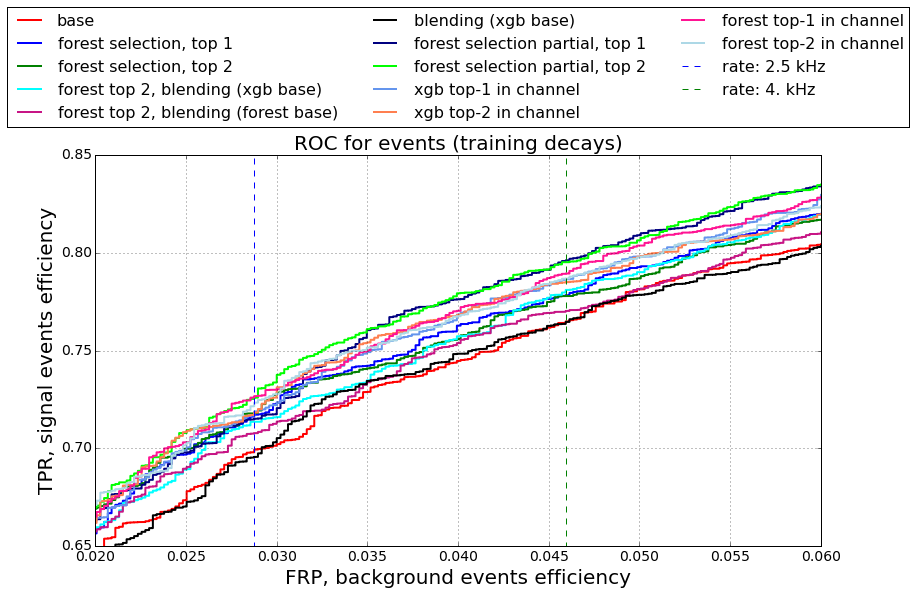

In [101]:
from rep.plotting import FunctionsPlot
FunctionsPlot(plots).plot(new_plot=True, xlim=(0.02, 0.06), ylim=(0.65, 0.85))
plot([1. * events_pass['2500.0-base'] / statistic_length(ds_test_bck)['Events']] * 2, 
     [0., 1], 'b--', label='rate: 2.5 kHz')
plot([1. * events_pass['4000.0-base'] / statistic_length(ds_test_bck)['Events']] * 2, 
     [0., 1], 'g--', label='rate: 4. kHz')
lgd = legend(loc='upper center', fontsize=16, bbox_to_anchor=(0.5, 1.4), ncol=3)
title('ROC for events (training decays)', fontsize=20)
xlabel('FRP, background events efficiency', fontsize=20)
ylabel('TPR, signal events efficiency', fontsize=20)

### without blending models

In [102]:
plots_new = plots.copy()
for key in plots_new:
    if 'blending' in key:
        plots_new.pop(key)

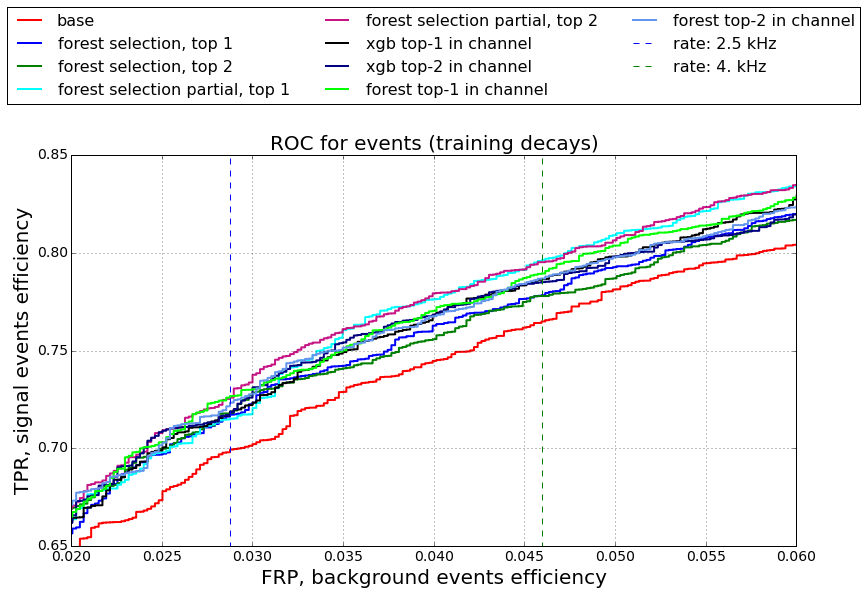

In [103]:
from rep.plotting import FunctionsPlot
FunctionsPlot(plots_new).plot(new_plot=True, xlim=(0.02, 0.06), ylim=(0.65, 0.85))
plot([1. * events_pass['2500.0-base'] / statistic_length(ds_test_bck)['Events']] * 2, 
     [0., 1], 'b--', label='rate: 2.5 kHz')
plot([1. * events_pass['4000.0-base'] / statistic_length(ds_test_bck)['Events']] * 2, 
     [0., 1], 'g--', label='rate: 4. kHz')
lgd = legend(loc='upper center', fontsize=16, bbox_to_anchor=(0.5, 1.4), ncol=3)
title('ROC for events (training decays)', fontsize=20)
xlabel('FRP, background events efficiency', fontsize=20)
ylabel('TPR, signal events efficiency', fontsize=20)

### roc for all channels

In [104]:
plots_all = OrderedDict()
for key, value in estimators.items():
    plots_all[key] = plot_roc_events(value, pandas.concat([test[test['signal'] == 1]] + all_channels), 
                                     test[test['signal'] == 0], key)

base AUC: 0.897540507956
forest selection, top 1 AUC: 0.887598478784
forest selection, top 2 AUC: 0.887829296524
forest top 2, blending (xgb base) AUC: 0.88628903539
forest top 2, blending (forest base) AUC: 0.88762946123
blending (xgb base) AUC: 0.894171879608
forest selection partial, top 1 AUC: 0.90247856949
forest selection partial, top 2 AUC: 0.900624881021
xgb top-1 in channel AUC: 0.890604249363
xgb top-2 in channel AUC: 0.890286580596
forest top-1 in channel AUC: 0.892192941604
forest top-2 in channel AUC: 0.891210950224


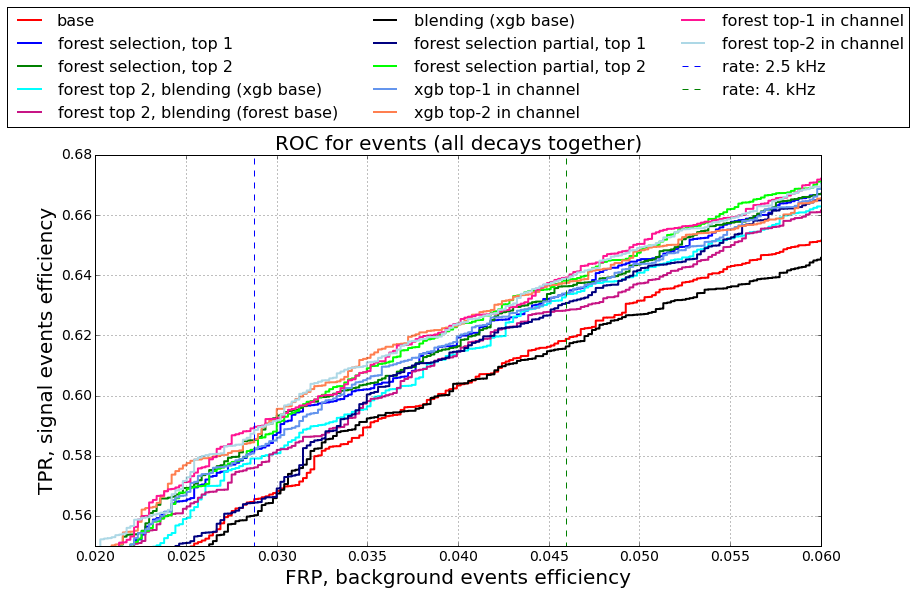

In [105]:
from rep.plotting import FunctionsPlot
FunctionsPlot(plots_all).plot(new_plot=True, xlim=(0.02, 0.06), ylim=(0.55, 0.68))
plot([1. * events_pass['2500.0-base'] / statistic_length(ds_test_bck)['Events']] * 2, 
     [0., 1], 'b--', label='rate: 2.5 kHz')
plot([1. * events_pass['4000.0-base'] / statistic_length(ds_test_bck)['Events']] * 2, 
     [0., 1], 'g--', label='rate: 4. kHz')
lgd = legend(loc='upper center', fontsize=16, bbox_to_anchor=(0.5, 1.4), ncol=3)
title('ROC for events (all decays together)', fontsize=20)
xlabel('FRP, background events efficiency', fontsize=20)
ylabel('TPR, signal events efficiency', fontsize=20)

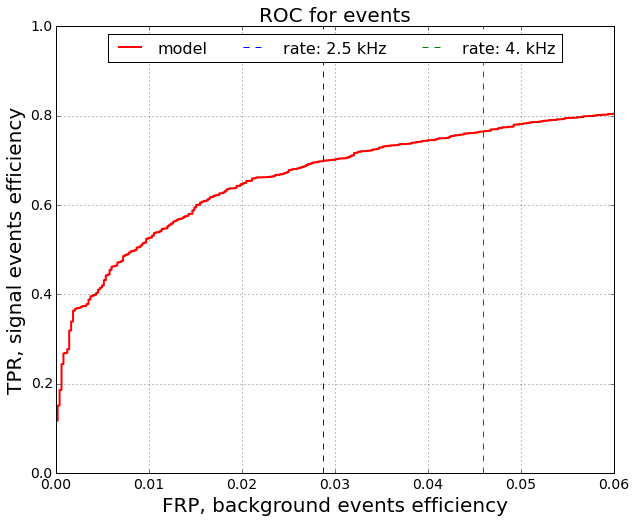

In [106]:
from rep.plotting import FunctionsPlot
FunctionsPlot({'model': plots['base']}).plot(new_plot=True, figsize=(10, 8), xlim=(0.0, 0.06), ylim=(0., 1))
plot([1. * events_pass['2500.0-base'] / statistic_length(ds_test_bck)['Events']] * 2, 
     [0., 1], 'b--', label='rate: 2.5 kHz')
plot([1. * events_pass['4000.0-base'] / statistic_length(ds_test_bck)['Events']] * 2, 
     [0., 1], 'g--', label='rate: 4. kHz')
lgd = legend(loc='upper center', fontsize=16, bbox_to_anchor=(0.5, 1.), ncol=3)
title('ROC for events', fontsize=20)
xlabel('FRP, background events efficiency', fontsize=20)
ylabel('TPR, signal events efficiency', fontsize=20)